In [225]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy import units as u
import twentyonecmFAST as tof
import sys

In [104]:
z = 10

In [108]:
def wedge_cube(z, theta, kx, ky):
    """
    Returns a cube of ones and zeros corresponding the characteristic angle, theta
    """
    kx, ky = np.meshgrid(kx, ky) * u.Mpc ** -1
    kz = np.sin(theta) * (((cosmo.H0 * cosmo.efunc(z) * cosmo.comoving_transverse_distance(z)) / 
                          (const.c * (1+z))) * np.sqrt(kx ** 2 + ky ** 2))
    return kz

def wedge_2d(z, theta, k_perp):
    """
    Returns a cube of ones and zeros corresponding the characteristic angle, theta
    """
    k_perp *= u.Mpc ** -1
    kz = np.sin(theta) * (((cosmo.H0 * cosmo.efunc(z) * cosmo.comoving_transverse_distance(z)) / 
                          (const.c * (1+z))) * k_perp)
    return kz

In [192]:
k_perp, k_par = np.meshgrid(np.sqrt(kx ** 2 + ky ** 2), kz)
kz_wedge_2d = wedge_2d(z, np.pi / 9.0, np.sqrt(kx ** 2 + ky ** 2)).to(u.Mpc ** -1)
wedge = np.zeros((256,256))

In [193]:
wedge[np.where(np.abs(k_par) > kz_wedge_2d.value)] += 1

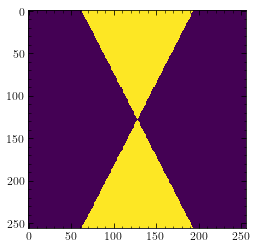

In [194]:
plt.imshow(wedge)
plt.show()

In [211]:
x = np.linspace(0, 1600, 256)
wedge = np.zeros((256,256,256))
_, kx, ky, kz = tof.calc_FT_cube(wedge, x, x, x)
kz_wedge = wedge_cube(z, np.pi / 18.0, kx, ky).to(u.Mpc ** -1)
kx, ky, kz = np.meshgrid(kx, ky, kz, indexing = 'ij')
wedge[np.where(np.abs(kz) > kz_wedge.value)] += 1

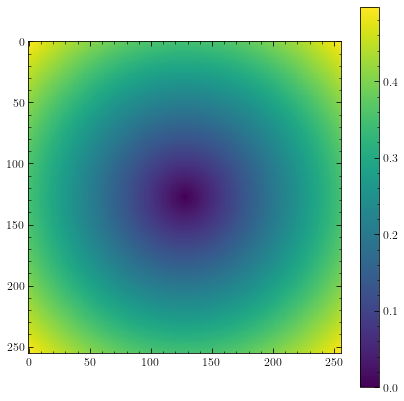

In [212]:
plt.figure(figsize=(7,7))
plt.imshow(kz_wedge.value)
plt.colorbar()
plt.show()

In [226]:
def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.frombuffer(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

In [239]:
Ts = load_binary_data('../../data/delta_T_v3_z010.04_nf0.905037_useTs1_256_200Mpc')
Ts = Ts.reshape((256,256,256))

In [240]:
Ts_twidle, _, _, _ = tof.calc_FT_cube(Ts, x, x, x)

In [242]:
new_Ts, _, _, _ = tof.calc_FT_cube(Ts_twidle * wedge, x, x, x, invert = True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


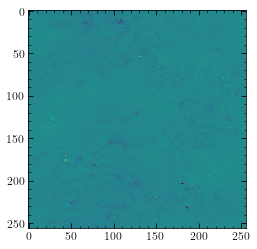

In [248]:
plt.imshow(new_Ts.astype('float')[:, :, 128])
plt.show()

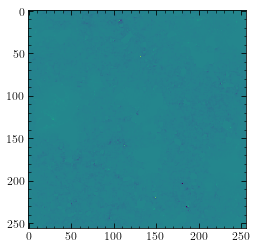

In [234]:
plt.imshow(Ts[:, :, 128])